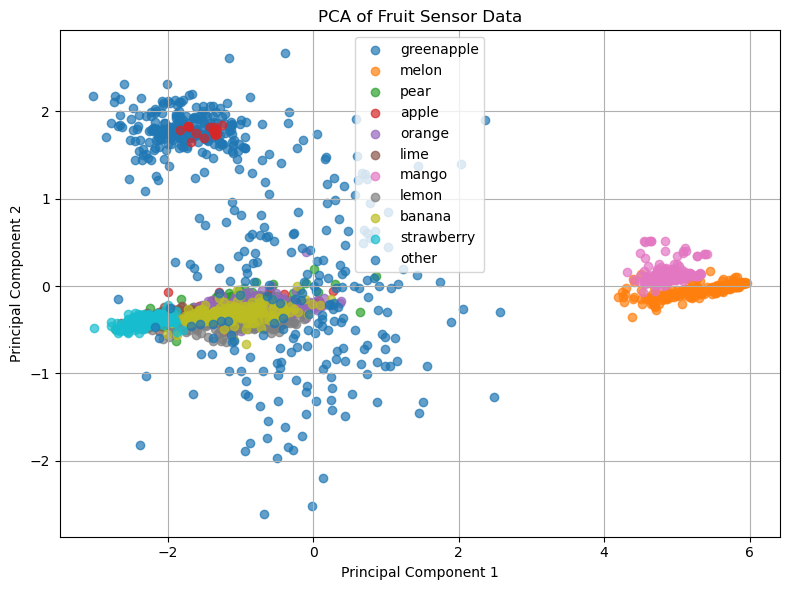

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 1, 'svm__kernel': 'rbf'}
Best CV accuracy: 0.928045310125708

--- Best Model Test Evaluation ---
Test Accuracy: 0.9243697478991597
              precision    recall  f1-score   support

       apple       0.96      0.77      0.85        30
      banana       0.70      0.83      0.76        42
  greenapple       1.00      0.98      0.99        49
       lemon       1.00      0.94      0.97        33
        lime       0.93      0.98      0.96        56
       mango       1.00      1.00      1.00        48
       melon       1.00      1.00      1.00        49
      orange       0.81      0.80      0.80        44
       other       0.96      1.00      0.98        45
        pear       0.89      0.89      0.89        45
  strawberry       0.97      0.89      0.93        35

    accuracy                           0.92       476
   macro avg       0.93      0.92      0.92       476
wei

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# -------------------------------------
# 1. Load and clean labeled fruit data
# -------------------------------------
df = pd.read_csv('merged_with_other.csv')

# Drop rows without labels
df = df.dropna(subset=['Label'])
df=df.dropna(subset=['Timestamp'])

# --------------------------
# 2. Feature and label setup
# --------------------------
features = ['ContactCount', 'Sensor1', 'Sensor2','Sensor3','Sensor4','Sensor5','Sensor6', 'WeightSensorAvg','Weight']
X = df[features]
y = df['Label']

# -------------------------------
# 3. Train/test split & scaling
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------------------
# 4. PCA for visual inspection (on all data)
# ------------------------------------------
scaler = StandardScaler()
X_scaled_full = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_full)

plt.figure(figsize=(8, 6))
for label in y.unique():
    plt.scatter(
        X_pca[y == label, 0],
        X_pca[y == label, 1],
        label=label,
        alpha=0.7
    )
plt.title("PCA of Fruit Sensor Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 5. Define pipeline and GridSearchCV for SVM tuning
# --------------------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid = [
    {
        'svm__kernel': ['linear'],
        'svm__C': [0.1, 1, 10, 100]
    },
    {
        'svm__kernel': ['rbf'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 0.01, 0.1, 1]
    }
]

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

grid.fit(X_train, y_train)

# --------------------------------
# 6. Report best model & evaluate
# --------------------------------
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Best Model Test Evaluation ---")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


# ------------------------------
# 7. Random Forest for comparison
# ------------------------------
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("\n--- Random Forest Results ---")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))
